In [1]:
import cv2 as cv
import numpy as np
from skimage import transform

import matplotlib.pyplot as plt


## Functions to be Used Throughout the Program

A comprehensive list of all functions used during the image registration process. Run this cluster to access all functions or run individually to gain access to specfic functions.

In [10]:
def downsize_image(img, scale_percent):
  """
  Downsize the image by a given percent
  """
  print('Original Dimensions : ',img.shape)

  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)

  print('Resized Dimensions : ',resized.shape)

  return resized

In [11]:
# upscale percentage
def refactor_dim(dims, scale_percent):
  """
  Upscale the image by a given percent
  """

  upscale_factor = 100/scale_percent
  return dims*upscale_factor

In [12]:
def get_crop_indices(crop, scale_percent):
  """
  Get the indices from the crop
  """

  verticies = []
  for i in range(len(crop.children)-1):
    verticies.append(crop.children[i].value)
  verticies = refactor_dim(np.asarray(verticies), scale_percent)
  return verticies

In [13]:
def calc_translation(fixed, moving, scale, t_form, adjust):
  """
  fixed: top left coordinate of box in the fixed image [x, y, 1]
  moving: top left coordinate of the box in the moving image [x, y, 1]
  scale : 3x3 scaling matrix to be applied to moving coordiante
  t_form: optimized transformation matrix to be applied to moving coordinate
  adjust:  the matlab calculated translation values

  returns: the translation in the x and y direction
  """

  scaled_coord = moving @ scale
  transformed_coord = scaled_coord @ t_form

  diff = np.abs(transformed_coord - fixed)

  translation = diff+adjust

  return translation

In [14]:
# perform the Mutual Information Calculation
def mutual_information(fixed, moving, bin_num):
  """
  Compute the Mutual information between the two images
  Code Adapted from https://matthew-brett.github.io/teaching/mutual_information.html
  """

  # check to make sure that fixed and moving are the same shape
  if fixed.shape != moving.shape:
    msg = f"""Fixed and moving images are not of the same shape.
              Fixed: {fixed.shape}, Moving: {moving.shape}"""
    raise ValueError(msg)

  hist, _, _ = np.histogram2d(fixed.ravel(), moving.ravel(), bins = bin_num)

  pxy = hist/float(np.sum(hist))
  px = np.sum(pxy, axis =1)
  py = np.sum(pxy, axis = 0)
  px_py = px[:, None]*py[None, :]

  nzs = pxy > 0
  return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

## Load the Images to be Registered

In [9]:

xenium_im = cv.imread('drive/MyDrive/spatial-transcriptomics/Xenium/he_image.ome.tif')
xenium_im = cv.cvtColor(xenium_im, cv.COLOR_BGR2GRAY)
xenium_im = cv.rotate(xenium_im, cv.ROTATE_90_CLOCKWISE)

visium_im = cv.imread('drive/MyDrive/spatial-transcriptomics/tissue_image.tif')
visium_im = cv.cvtColor(visium_im, cv.COLOR_BGR2GRAY)

## SIFT Keypoints and Registration

In [8]:
def register_images(xenium, visium):
  """
  Function used to register xenium and visium crops using SIFT and RANSAC

  Code Adapted from:
  https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/
  https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/
  """
  sift = cv.SIFT_create()

  key1, des1 = sift.detectAndCompute(xenium, None)
  key2, des2 = sift.detectAndCompute(visium, None)

  # match features
  matcher = cv.BFMatcher(cv.NORM_L1, crossCheck = True)
  matches = matcher.match(des1, des2)

  # sort matches by score
  matches = sorted(matches, key = lambda x:x.distance, reverse=False)

  # remove not so good matches
  numGoodMatches = int(len(matches)*0.3)
  matches = matches[:numGoodMatches]

  imMatches = cv.drawMatches(xenium, key1, visium, key2, matches, None)
  cv.imwrite("matches.jpg", imMatches)

  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = key1[match.queryIdx].pt
    points2[i, :] = key2[match.trainIdx].pt

  # Find homography
  h, mask = cv.findHomography(points1, points2, cv.RANSAC)

  # Use homography
  height, width = visium.shape
  im1Reg = cv.warpPerspective(xenium, h, (width, height))

  return im1Reg, h

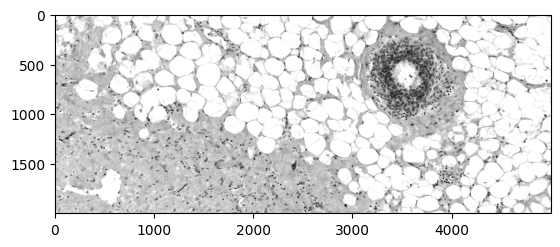

In [3]:
xenium_sift = cv.imread('drive/MyDrive/spatial-transcriptomics/Xenium/he_image.tif')
xenium_sift = cv.cvtColor(xenium_sift, cv.COLOR_BGR2GRAY)

cropped_x = xenium_sift[5000:7000, 12000:17000]
plt.imshow(cropped_x, cmap = 'gray')

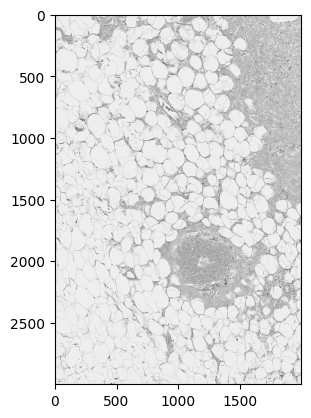

In [4]:
visium_sift = cv.imread('drive/MyDrive/spatial-transcriptomics/tissue_image.tif')
visium_sift = cv.cvtColor(visium_sift, cv.COLOR_BGR2GRAY)

cropped_v = visium_sift[10000:13000, 6000:8000]
plt.imshow(cropped_v, cmap = 'gray')

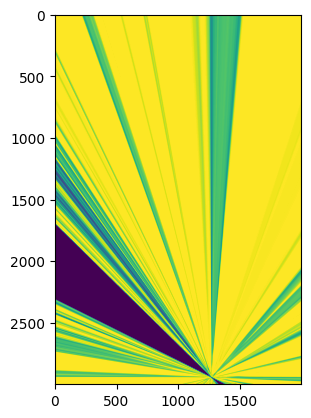

In [9]:
reg, h = register_images(cropped_x, cropped_v)
plt.imshow(reg)

## Get the crop

Crop the image using an interactive slider to see where the crop is

In [24]:
import ipywidgets as widgets
from IPython.display import display

# Function to display image and handle cropping
def crop_image(x_start, y_start, x_end, y_end):

    # Draw a rectangle around the region of interest
    image_with_rect = xenium.copy()
    cv.rectangle(image_with_rect, (x_start, y_start), (x_end, y_end), (0, 255, 0), 20)
    plt.imshow(cv.cvtColor(image_with_rect, cv.COLOR_BGR2RGB))
    plt.show()

# Load the and downsize the image
scale_percent = 10
xenium = downsize_image(xenium_im, scale_percent)
max_y, max_x = xenium.shape

# Set up interactive cropping with sliders
x_start_slider = widgets.IntSlider(value = 0, min = 0, max = max_x, step = 1, description = 'X Start')
y_start_slider = widgets.IntSlider(value=0, min=0, max=max_y, step=1, description = 'Y Start')
x_end_slider = widgets.IntSlider(value = max_x, min = 0, max = max_x, step = 1, description = 'X End')
y_end_slider = widgets.IntSlider(value = max_y, min = 0, max = max_y, step = 1, description = 'Y End')

interactive_crop = widgets.interactive(crop_image,
                                       x_start = x_start_slider,
                                       y_start = y_start_slider,
                                       x_end = x_end_slider,
                                       y_end = y_end_slider)

display(interactive_crop)

Original Dimensions :  (35416, 25778)
Resized Dimensions :  (3541, 2577)


interactive(children=(IntSlider(value=0, description='X Start', max=2577), IntSlider(value=0, description='Y S…

In [16]:
xenium_indices = get_crop_indices(interactive_crop, scale_percent)
print(xenium_indices)

[ 1410. 16630.  5500. 21000.]


1410.0


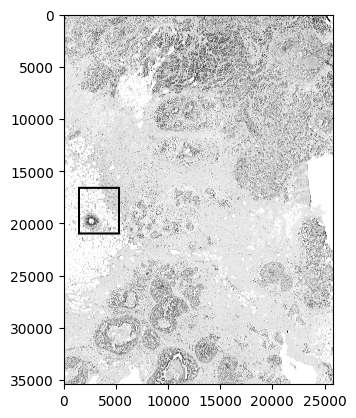

In [11]:

image_with_rect = xenium_im.copy()
print(xenium_indices[0])
cv.rectangle(image_with_rect, (int(xenium_indices[0]), int(xenium_indices[1])), (int(xenium_indices[2]), int(xenium_indices[3])), (0, 255, 0), 200)
plt.imshow(cv.cvtColor(image_with_rect, cv.COLOR_BGR2RGB))

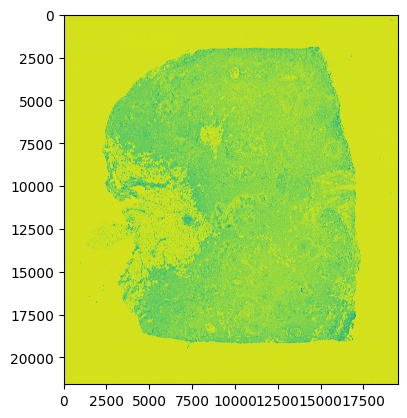

In [12]:
plt.imshow(visium_im)

Do this for visium data as well, interactively grab a crop and visualize the crop

In [17]:
# Function to display image and handle cropping
def crop_image(x_start, y_start, x_end, y_end):
    # Draw a rectangle around the region of interest
    image_with_rect = visium.copy()
    cv.rectangle(image_with_rect, (x_start, y_start), (x_end, y_end), (0, 255, 0), 10)
    plt.imshow(cv.cvtColor(image_with_rect, cv.COLOR_BGR2RGB))
    plt.show()

# Load the image
scale_percent = 10
visium = downsize_image(visium_im, scale_percent)
max_y, max_x = visium.shape

# Set up interactive cropping with sliders
x_start_slider = widgets.IntSlider(value = 0, min = 0, max = max_x, step = 1, description = 'X Start')
y_start_slider = widgets.IntSlider(value=0, min=0, max=max_y, step=1, description = 'Y Start')
x_end_slider = widgets.IntSlider(value = max_x, min = 0, max = max_x, step = 1, description = 'X End')
y_end_slider = widgets.IntSlider(value = max_y, min = 0, max = max_y, step = 1, description = 'Y End')

interactive_crop = widgets.interactive(crop_image,
                                       x_start = x_start_slider,
                                       y_start = y_start_slider,
                                       x_end = x_end_slider,
                                       y_end = y_end_slider)

display(interactive_crop)

Original Dimensions :  (21571, 19505)
Resized Dimensions :  (2157, 1950)


interactive(children=(IntSlider(value=0, description='X Start', max=1950), IntSlider(value=0, description='Y S…

In [18]:
visium_indices = get_crop_indices(interactive_crop, scale_percent)
print(visium_indices)

[ 6670. 10680.  8710. 12770.]


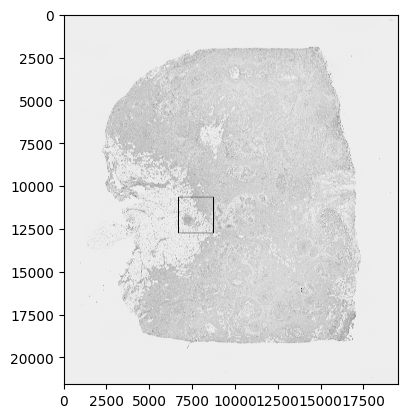

In [15]:
image_with_rect = visium_im.copy()

cv2.rectangle(image_with_rect, (int(visium_indices[0]), int(visium_indices[1])), (int(visium_indices[2]), int(visium_indices[3])), (0, 255, 0), 20)
plt.imshow(cv2.cvtColor(image_with_rect, cv2.COLOR_BGR2RGB))

Original Dimensions :  (4370, 3840)
Resized Dimensions :  (2185, 1920)


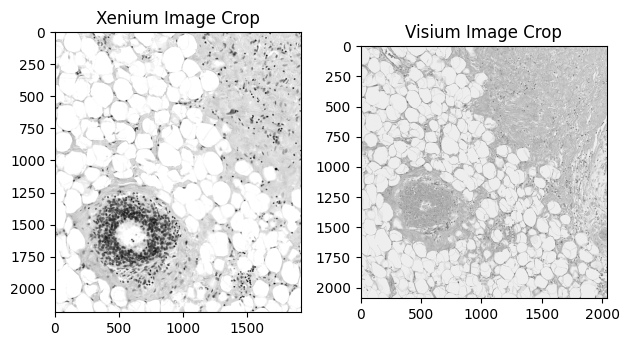

In [16]:
## save out both image crops
visium_crop = visium_im[int(visium_indices[1]): int(visium_indices[3]), int(visium_indices[0]): int(visium_indices[2])]
xenium_crop = xenium_im[int(xenium_indices[1]): int(xenium_indices[3]), int(xenium_indices[0]): int(xenium_indices[2])]

xenium_resize = downsize_image(xenium_crop, 50)

cv.imwrite("visium1.png", visium_crop)
cv.imwrite("xenium1.png", xenium_resize)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(xenium_resize, cmap = "gray")
ax[0].set_title("Xenium Image Crop")

ax[1].imshow(visium_crop, cmap = "gray")
ax[1].set_title('Visium Image Crop')

fig.tight_layout()
plt.show()

## Register the Image

In [20]:
import numpy as np
scale = np.array([
    [0.5, 0, 0],
    [0, 0.5, 0],
    [0, 0, 1]
])

xenium_pt = np.array([1410, 16630, 1])
visium_pt = np.array([6670, 10680,1])

# matrix from the matlab solution
m_t_form = np.array([
    [0.7776, -0.0436, 0],
    [0.0394, 0.7782, 0],
    [3.3632, 114.9536, 1]
])
t_form = np.array([
    [0.7776, -0.0436, 0],
    [0.0394, 0.7782, 0],
    [0, 0, 1]
])
adjust = m_t_form[2]

translation = calc_translation(visium_pt, xenium_pt, scale, t_form, adjust)

t_form[2] = translation
print(t_form)

[[ 7.7760000e-01 -4.3600000e-02  0.0000000e+00]
 [ 3.9400000e-02  7.7820000e-01  0.0000000e+00]
 [ 5.7975442e+03  4.3549586e+03  1.0000000e+00]]


In [21]:
# check that scaling and downsizing produces the same image
scale = np.array([
    [0.5, 0, 0],
    [0, 0.5, 0],
    [0, 0, 1]
])
scale = scale.transpose()

scaled = transform.warp(xenium_im, np.linalg.inv(scale))


Original Dimensions :  (35416, 25778)
Resized Dimensions :  (17708, 12889)


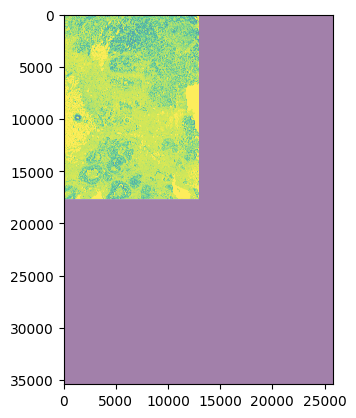

In [33]:
# Resize the whole xenium image
resized_im = downsize_image(xenium_im, 50)

plt.imshow(resized_im, alpha = 0.5)
plt.imshow(scaled, alpha = 0.5)

In [22]:
# Apply the transformation to the Image

t_form = t_form.transpose()

# transform the whole image
registered = transform.warp(scaled, np.linalg.inv(t_form))

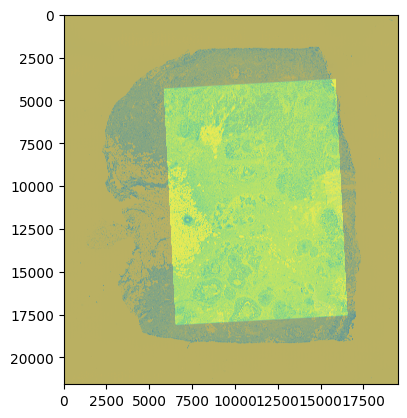

In [36]:
plt.imshow(registered, alpha = 0.5)
plt.imshow(visium_im, alpha = 0.5)

In [23]:
# with found coordinates (newest) - Final Calcualte tx = , ty =
print(mutual_information(visium_im, registered[:visium_im.shape[0], : visium_im.shape[1]], 50))

0.19603547557656933


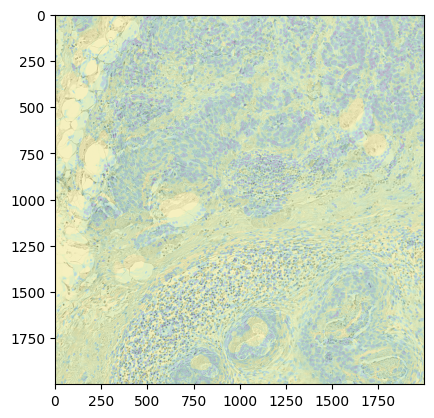

In [ ]:
plt.imshow(registered[6000:8000, 9000:11000], alpha = 0.5)
plt.imshow(visium_im[6000:8000, 9000:11000], cmap = 'gray', alpha = 0.5)

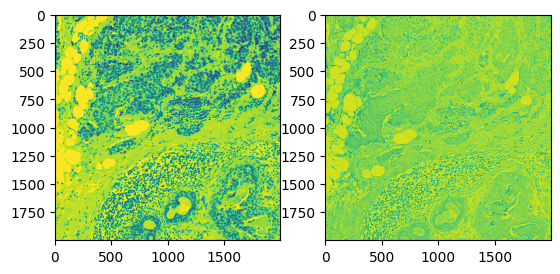

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(registered[6000:8000, 9000:11000])
ax[1].imshow(visium_im[6000:8000, 9000:11000])

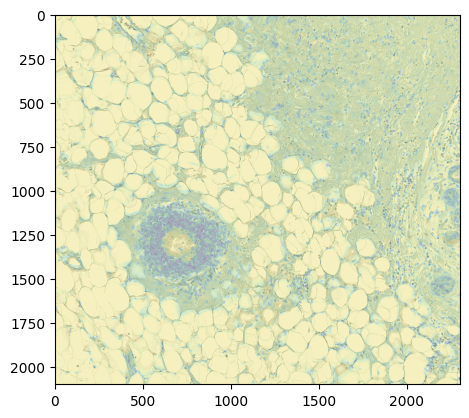

In [ ]:
plt.imshow(registered[10700:12800, 6500:8800], alpha = 0.5)
plt.imshow(visium_im[10700:12800, 6500:8800], cmap = 'gray', alpha = 0.5)

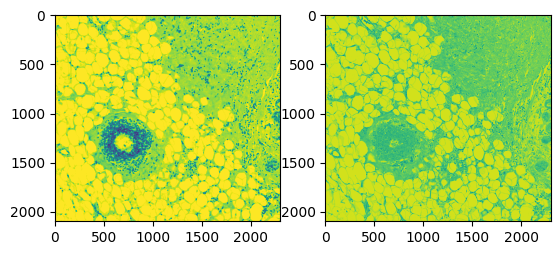

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(registered[10700:12800, 6500:8800])
ax[1].imshow(visium_im[10700:12800, 6500:8800])

## Current Alignment on Xenium Explorer Datasets

In [ ]:
visium_im = cv.imread('drive/MyDrive/spatial-transcriptomics/tissue_image.tif')
visium_im = cv.cvtColor(visium_im, cv.COLOR_BGR2GRAY)
visium_im = cv.rotate(visium_im, cv.ROTATE_90_CLOCKWISE)
visium_im = cv.flip(visium_im, 1)

xenium_im = cv.imread('drive/MyDrive/spatial-transcriptomics/Xenium/he_image.ome.tif')
xenium_im = cv.cvtColor(xenium_im, cv.COLOR_BGR2GRAY)
#xenium_im = cv.flip(xenium_im, 1)


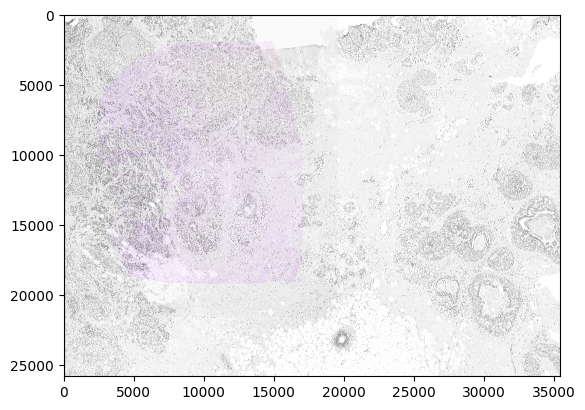

In [ ]:
plt.imshow(visium_im, alpha = 0.5)
plt.imshow(xenium_im, alpha = 0.5)

In [ ]:
t_form = np.array([
    [0.2125, 0, 0],
    [0, 0.2125, 0],
    [0, 0, 1]
])

scaled = transform.warp(xenium_im, np.linalg.inv(t_form))

In [ ]:
tform = np.array([[ 1.80556957e+00,  8.13588823e-02,  3.99634404e+03],
       [ 8.13588823e-02, -1.80556957e+00,  1.58239059e+04],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])


registered = transform.warp(scaled, np.linalg.inv(tform))

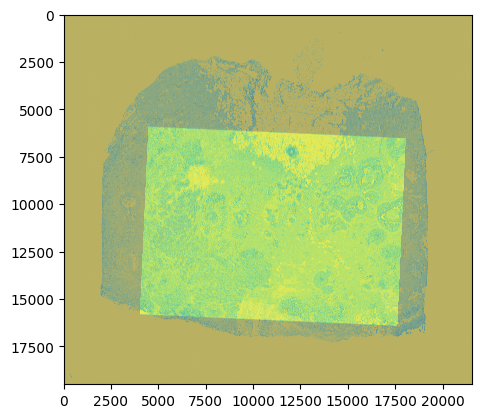

In [ ]:

plt.imshow(registered, alpha = 0.5)
plt.imshow(visium_im, alpha = 0.5)

In [ ]:
print(mutual_information(visium_im, registered[:visium_im.shape[0], : visium_im.shape[1]], 50))

0.18525297788239237


## Compute Intensity Histograms and Signal and Mutual Information Metric

code adpated from referencing: https://matthew-brett.github.io/teaching/mutual_information.html

In [ ]:
import matplotlib.pyplot as plt

# Make sure that the fixed and moving images are grayscale
fixed = cv.cvtColor(visium_im, cv.COLOR_BGR2GRAY)
moving = cv.cvtColor(xenium_im, cv.COLOR_BGR2GRAY)

registered = transform.warp(moving, np.linalg.inv(t_form))


# normalize the registered image to be between [0, 255]
norm_registered = cv.normalize(registered, None, alpha = 0, beta = 255, norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)

norm_registered = norm_registered.astype(np.uint8)


Text(0.5, 1.0, 'Moving Image Histogram')

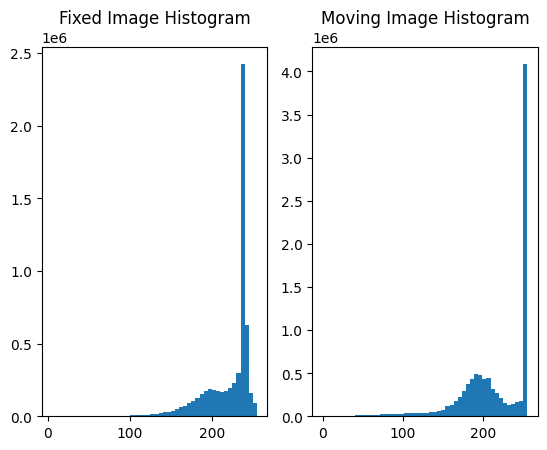

In [ ]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(fixed.ravel(), bins = 50)
axes[0].set_title("Fixed Image Histogram")

axes[1].hist(moving.ravel(), bins = 50)
axes[1].set_title("Moving Image Histogram")

Text(0.5, 1.0, 'Registered Image Histogram')

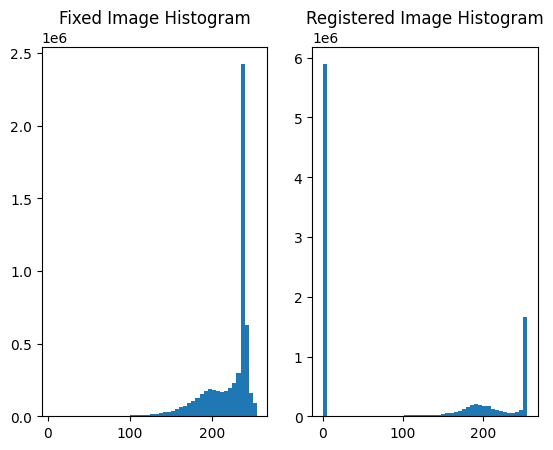

In [ ]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(fixed.ravel(), bins = 50)
axes[0].set_title("Fixed Image Histogram")

axes[1].hist(norm_registered.ravel(), bins = 50)
axes[1].set_title("Registered Image Histogram")

Text(0.5, 1.0, 'Overlapped Slice of Fixed and Moving Image (unregistered)')

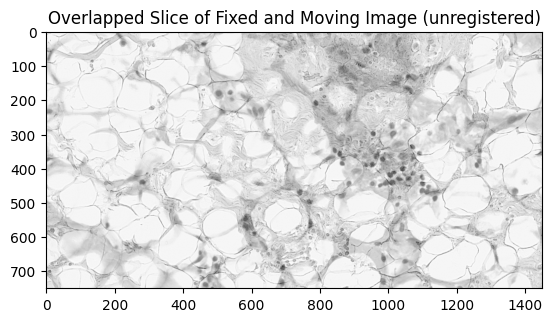

In [ ]:
# unregsitered slice
plt.imshow(fixed[1250:, 50:1500], cmap = 'gray')
plt.imshow(moving[1250:, 50:1500], cmap = 'gray', alpha = 0.5)
plt.title("Overlapped Slice of Fixed and Moving Image (unregistered)")

Text(0, 0.5, 'Unregistered Xenium Intensities')

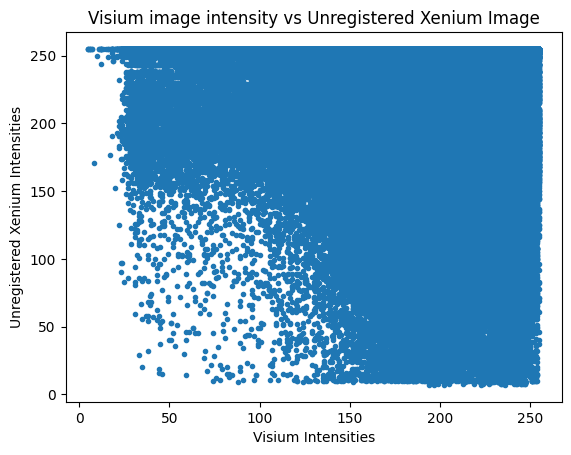

In [ ]:
plt.plot(fixed[1250:, 50:1500].ravel(), moving[1250:, 50:1500].ravel(), '.')
plt.title("Visium image intensity vs Unregistered Xenium Image")
plt.xlabel("Visium Intensities")
plt.ylabel("Unregistered Xenium Intensities")

In [ ]:
# print the mutual information value
mutual_info = mutual_information(fixed[1250:, 50:1500], moving[1250:, 50:1500], bin_num = 50)
print(f"Mutual Information between Unregistered Slices: {mutual_info}")

Mutual Information between Unregistered Slices: 0.007226734600540422


Text(0.5, 1.0, 'Overlapped Slice of Fixed and Registered Image')

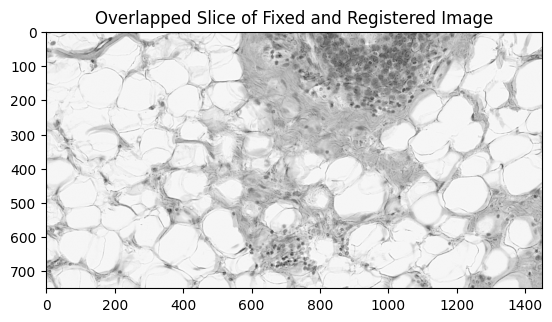

In [ ]:
# registered slice
plt.imshow(fixed[1250:, 50:1500], cmap = 'gray')
plt.imshow(norm_registered[1250:, 50:1500], cmap = 'gray', alpha = 0.5)
plt.title("Overlapped Slice of Fixed and Registered Image")

Text(0, 0.5, 'Registered Xenium Intensities')

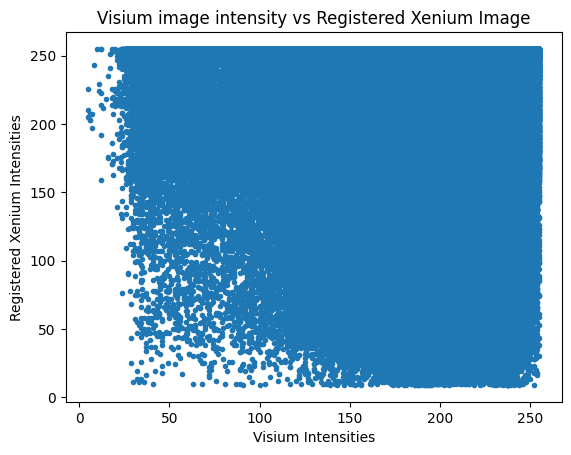

In [ ]:
plt.plot(fixed[1250:, 50:1500].ravel(), norm_registered[1250:, 50:1500].ravel(), '.')
plt.title("Visium image intensity vs Registered Xenium Image")
plt.xlabel("Visium Intensities")
plt.ylabel("Registered Xenium Intensities")

In [ ]:
mutual_info = mutual_information(fixed[1250:, 50:1500], norm_registered[1250:, 50:1500], bin_num = 50)
print(f"Mutual Information between Registered Slices: {mutual_info}")

Mutual Information between Registered Slices: 0.1926929928119635
